# Historical data
In this example used data from forecast archives web site https://rp5.ru/

You can download current archive from direct link:
https://github.com/ravil23/forecast/raw/master/data/27612.01.01.2005.11.08.2017.1.0.0.en.utf8.00000000.csv

In [1]:
%pylab inline
import pandas as pd
import os
import datetime
import warnings
warnings.filterwarnings('ignore')

# Include additional module
include_path = '../tensorflow_oop/'
if include_path not in sys.path:
    sys.path.append(include_path)
from tensorflow_oop.dataset import *

Populating the interactive namespace from numpy and matplotlib


## Clean historical data file

In [2]:
def clean_file(filename):
    """
    Clean historical data file and write result to new file.
    Input:
        filename : string
    Output:
        cleaned_filename : string
    """
    # Parse input file
    with open(filename) as f:
        lines = []
        for line in f:
            # Skip comment lines
            if line[0] != '#':
                line = line.replace('\n', '')
                line = line.replace('\r', '')
                if line[-1] == ';':
                    # Delete last empty delimiter
                    line = line[:-1]
                lines.append(line + '\n')

    # Write result to new file
    cleaned_filename = filename + '.cleaned.csv'
    with open(cleaned_filename, 'w') as f:
        f.writelines(lines)

    return cleaned_filename

In [3]:
FILENAME = '../data/27612.01.01.2005.11.08.2017.1.0.0.en.utf8.00000000.csv'

print('Cleaning...')
cleaned_filename = clean_file(FILENAME)
print('Cleaned filename: %s' % cleaned_filename)

Cleaning...
Cleaned filename: ../data/27612.01.01.2005.11.08.2017.1.0.0.en.utf8.00000000.csv.cleaned.csv


## Load dataframe

In [4]:
def load_dataframe(filename):
    """
    Load dataframe from csv.
    Input:
        filename : string
    Output:
        df : pandas.core.frame.DataFrame
    """
    # Read file
    df = pd.read_csv(filename, delimiter=';', quotechar='"')
    
    # Convert string to datetime format
    df['time'] = pd.to_datetime(df.iloc[:,0], format='%d.%m.%Y %H:%M')
    
    # Set time as index
    df = df.set_index('time')
    
    # Resample with timedelta 3 hours and fill new rows with NaN
    df = df.resample('3H').asfreq()
    
    # Preprocessing amount of precipitation
    df['RRR'] = df['RRR'].replace('No precipitation', 0.)
    df['RRR'] = df['RRR'].replace('Trace of precipitation', np.nan)
    df['RRR'] = pd.to_numeric(df['RRR'])
    return df

In [5]:
print('Loading...')
df = load_dataframe(cleaned_filename)
print('Loaded dataframe shape: %s' % str(df.shape))

df.head()

Loading...
Loaded dataframe shape: (36599, 29)


,Local time in Moscow,T,Po,P,Pa,U,DD,Ff,ff10,ff3,...,Cm,Ch,VV,Td,RRR,tR,E,Tg,E',sss
time,,,,,,,,,,,,,,,,,,,,,
2005-02-01 03:00:00,01.02.2005 03:00,-8.6,743.0,758.1,NaN,89.0,Wind blowing from the south-east,2.0,NaN,NaN,...,Altostratus translucidus.,"Cirrocumulus alone, or Cirrocumulus accompanie...",NaN,-10.1,NaN,NaN,NaN,NaN,NaN,NaN
2005-02-01 06:00:00,01.02.2005 06:00,-8.2,742.8,757.9,NaN,90.0,Wind blowing from the south-east,3.0,NaN,NaN,...,Altostratus translucidus.,"Cirrocumulus alone, or Cirrocumulus accompanie...",NaN,-9.6,2.0,12.0,NaN,NaN,NaN,NaN
2005-02-01 09:00:00,01.02.2005 09:00,-8.6,743.5,758.6,NaN,89.0,Wind blowing from the south-east,3.0,NaN,NaN,...,Altostratus translucidus.,"Cirrocumulus alone, or Cirrocumulus accompanie...",4,-10.1,3.0,12.0,NaN,NaN,Even layer of loose dry snow covering ground c...,43
2005-02-01 12:00:00,01.02.2005 12:00,-7.1,745.0,760.0,NaN,85.0,Wind blowing from the south-east,3.0,NaN,NaN,...,NaN,NaN,10,-9.2,NaN,NaN,NaN,NaN,NaN,NaN
2005-02-01 15:00:00,01.02.2005 15:00,-6.6,746.8,761.8,NaN,83.0,Wind blowing from the south-east,3.0,NaN,NaN,...,Altocumulus castellanus or floccus.,"Cirrocumulus alone, or Cirrocumulus accompanie...",4,-9.0,NaN,NaN,NaN,NaN,NaN,NaN


## Column types
1. T, температура воздуха (градусы Цельсия) на высоте 2 метра над поверхностью земли
2. Po, атмосферное давление на уровне станции (миллиметры ртутного столба)
3. P, атмосферное давление, приведенное к среднему уровню моря (миллиметры ртутного столба)
4. U, относительная влажность (%) на высоте 2 метра над поверхностью земли
5. DD, направление ветра (румбы) на высоте 10-12 метров над земной поверхностью, осредненное за 10-минутный период, непосредственно предшествовавший сроку наблюдения
6. FF, cкорость ветра на высоте 10-12 метров над земной поверхностью, осредненная за 10-минутный период, непосредственно предшествовавший сроку наблюдения (метры в секунду)
7. FF10, максимальное значение порыва ветра на высоте 10-12 метров над земной поверхностью за 10-минутный период, непосредственно предшествующий сроку наблюдения (метры в секунду)
8. FF3, максимальное значение порыва ветра на высоте 10-12 метров над земной поверхностью за период между сроками (метры в секунду)
9. Tn, минимальная температура воздуха (градусы Цельсия) за прошедший период (не более 12 часов)
10. Tx, максимальная температура воздуха (градусы Цельсия) за прошедший период (не более 12 часов)
11. Nh, количество всех наблюдающихся облаков Cl или, при отсутствии облаков Cl, количество всех наблюдающихся облаков Cm
12. H, высота основания самых низких облаков (м)
13. VV, горизонтальная дальность видимости (км)
14. RRR, количество выпавших осадков (миллиметры)
15. sss, высота снежного покрова (см)

In [6]:
df.dtypes

Local time in Moscow     object
T                       float64
Po                      float64
P                       float64
Pa                      float64
U                       float64
DD                       object
Ff                      float64
ff10                    float64
ff3                     float64
N                        object
WW                       object
W1                       object
W2                       object
Tn                      float64
Tx                      float64
Cl                       object
Nh                       object
H                        object
Cm                       object
Ch                       object
VV                       object
Td                      float64
RRR                     float64
tR                      float64
E                        object
Tg                      float64
E'                       object
sss                      object
dtype: object

## Features

### Temperature

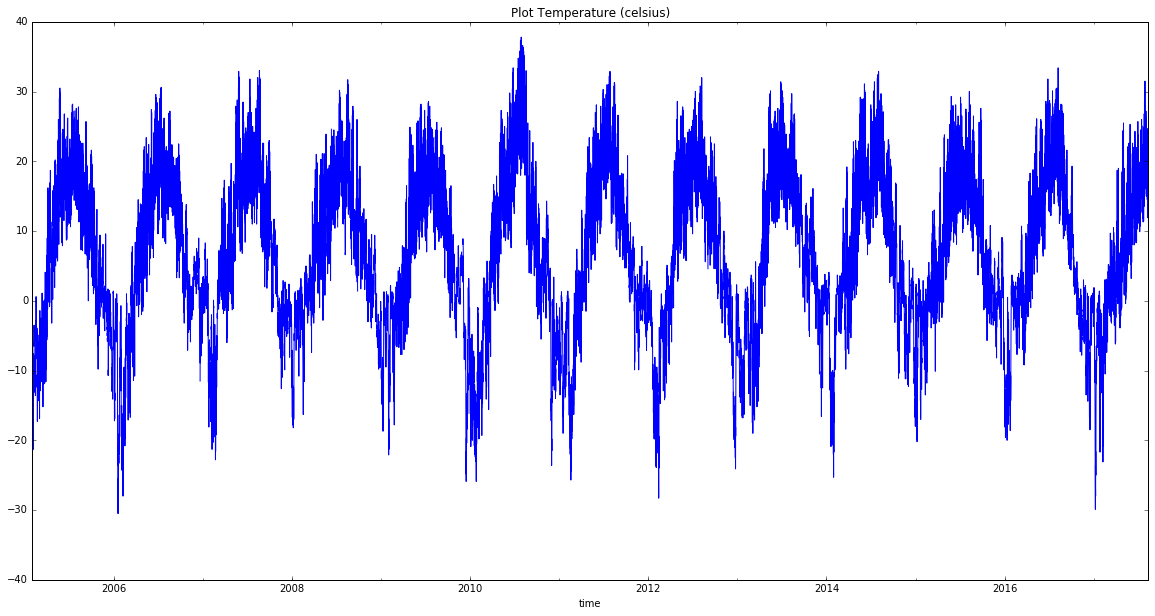

In [7]:
df['T'].plot(figsize=(20,10), title='Plot Temperature (celsius)')

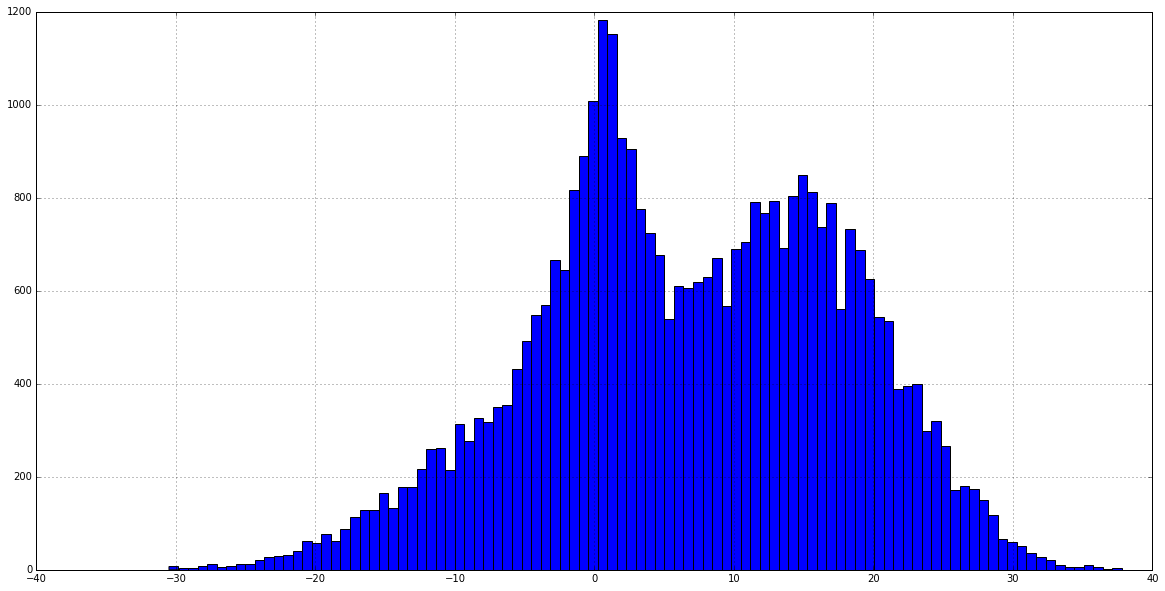

In [8]:
df['T'].hist(figsize=(20,10), bins=100)

### Atmospheric pressure at station level

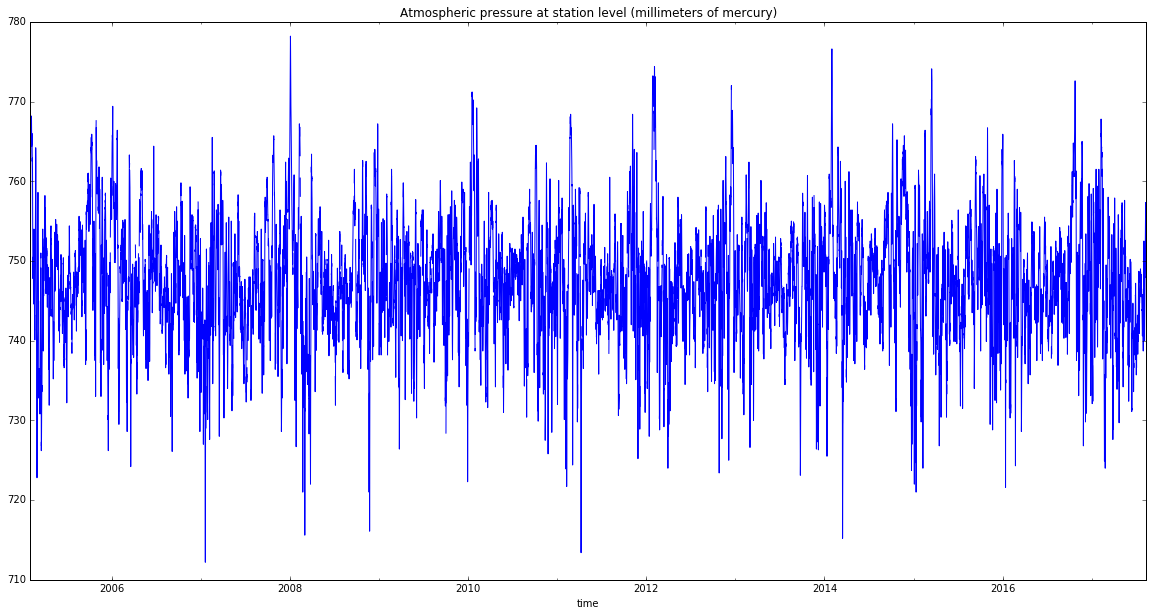

In [9]:
df['Po'].plot(figsize=(20,10), title='Atmospheric pressure at station level (millimeters of mercury)')

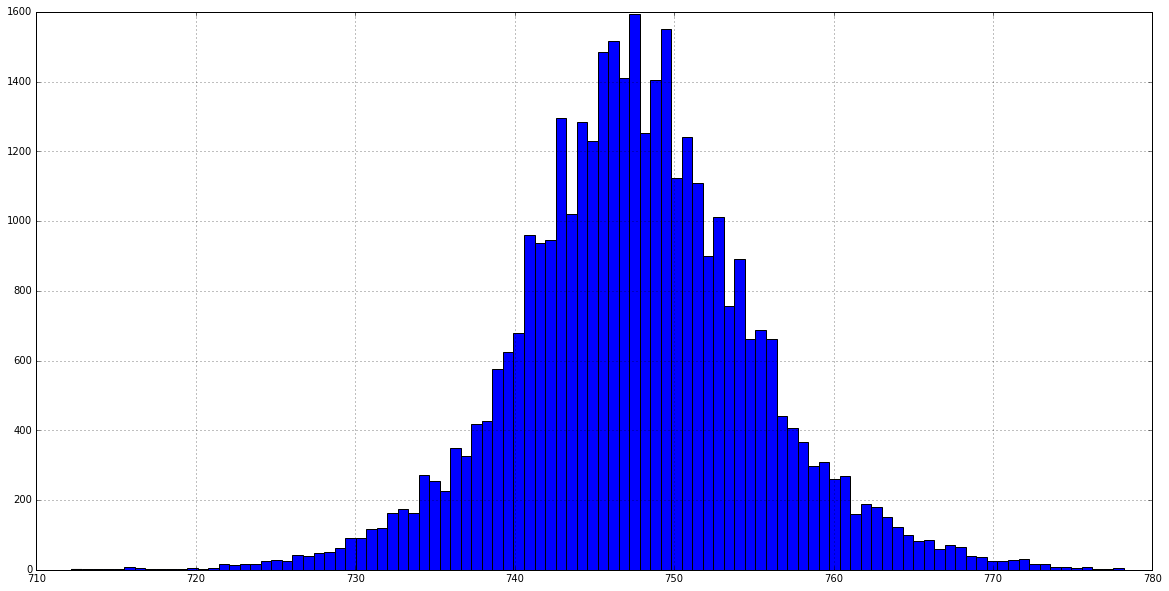

In [10]:
df['Po'].hist(figsize=(20,10), bins=100)

### Relative humidity

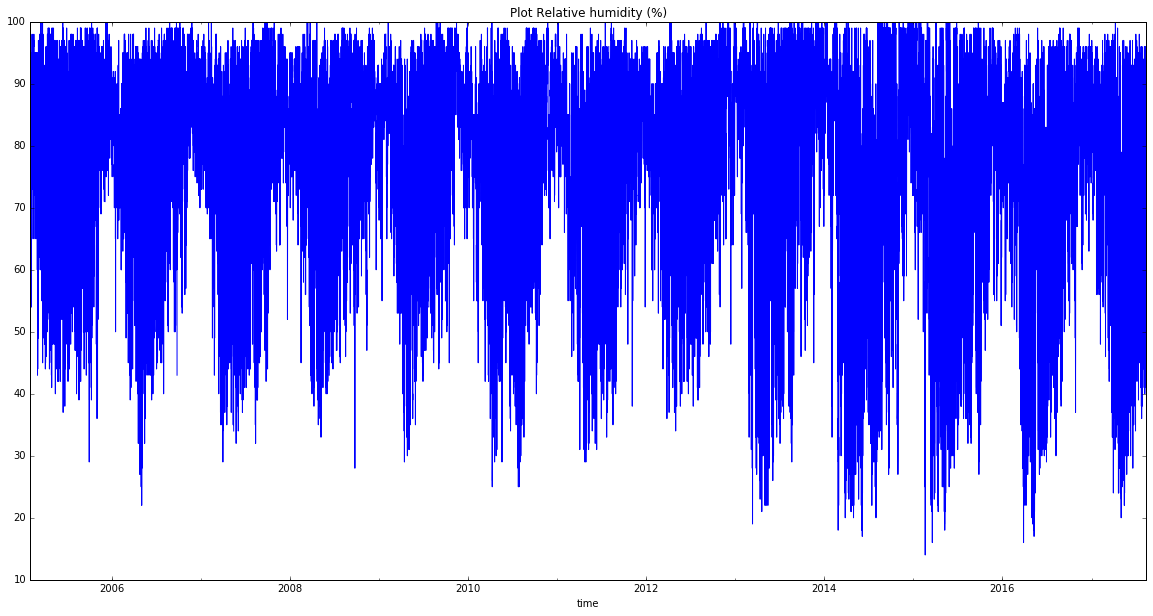

In [11]:
df['U'].plot(figsize=(20,10), title='Plot Relative humidity (%)')

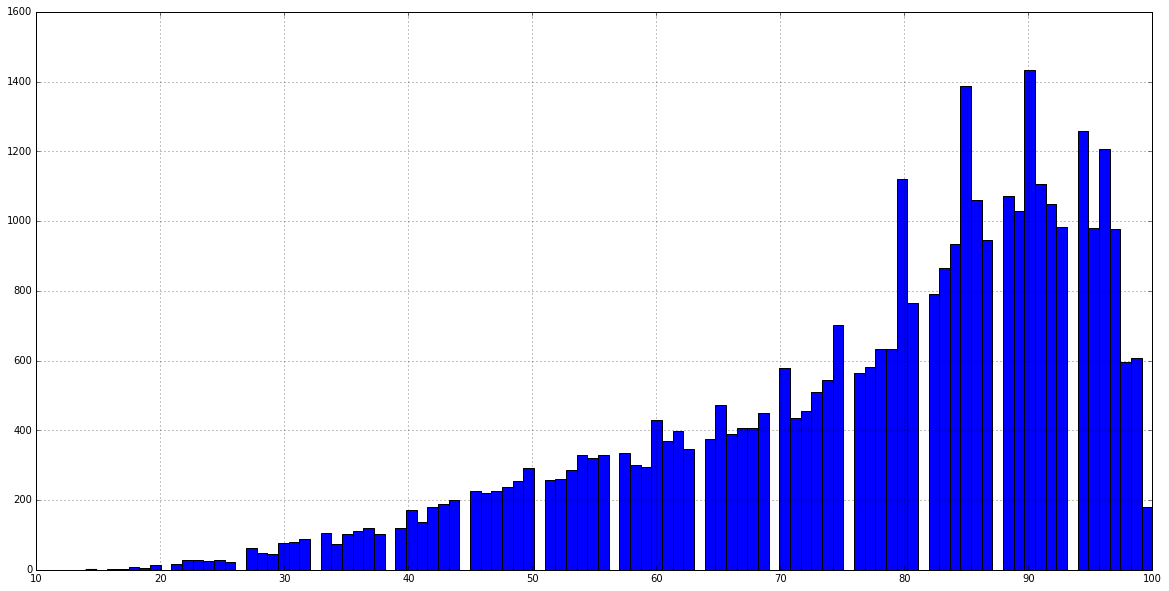

In [12]:
df['U'].hist(figsize=(20,10), bins=100)

### Create dataframe of features

In [13]:
df_features = df[['T','Po','U']]
print('Features shape: %s' % str(df_features.shape))

Features shape: (36599, 3)


## Preprocessing

### Interpolate NaN values

In [14]:
print('Interpolating...')
nan_count = df_features.isnull().sum()
df_features = df_features.interpolate()
print('Interpolated NaN values count:\n%s' % nan_count)

Interpolating...
Interpolated NaN values count:
T     187
Po    290
U     209
dtype: int64


### Convert to features set

In [15]:
print('Converting to features set...')
features = TFDataset(df_features.values)
print('Features set shape: %s' % (features.str_shape()))

Converting to features set...
Features set shape: 36599 : [3] -> None


### Normalize

In [16]:
print('Normalizing...')
features.normalize()
print('Normalized with parameters:')
print('\tmean: %s' % features.normalization_mean)
print('\tstd: %s' % features.normalization_std)

Normalizing...
Normalized with parameters:
	mean: 277.091420075
	std: 334.156940913


## Dataset

### Generate dataset of sequences

In [17]:
SEQUENCE_LENGTH = 32
SEQUENCE_STEP = 1
LABEL_LENGTH = 1
LABEL_OFFSET = 0

print('Generating dataset...')
dataset = features.generate_sequences(SEQUENCE_LENGTH, SEQUENCE_STEP, LABEL_LENGTH, LABEL_OFFSET)
print('Dataset shape: %s' % (dataset.str_shape()))

Generating dataset...
Dataset shape: 36567 : [32, 3] -> [1, 3]


### Save dump of dataset

In [18]:
DUMP_PATH = '../data/moscow.dump'

print('Saving dataset...')
dataset.save(DUMP_PATH)
print('Dataset saved to: %s' % DUMP_PATH)

Saving dataset...
Dataset saved to: ../data/moscow.dump


### Load dump of dataset

In [19]:
print('Loading dataset...')
dataset.load(DUMP_PATH)
print(dataset)

Loading dataset...
TFDataset object:
                init: True
                size: 36567
          data_shape: [32, 3]
           data_ndim: 2
        labels_shape: [1, 3]
         labels_ndim: 2
          batch_size: 1
           batch_num: 0
          normalized: True
  normalization_mask: None
  normalization_mean: 277.091420075
   normalization_std: 334.156940913
data: 
[[[-0.8549618   1.39428072 -0.56288347]
  [-0.85376476  1.3936822  -0.55989087]
  [-0.8549618   1.39577702 -0.56288347]
  ..., 
  [-0.86453814  1.46849734 -0.63470601]
  [-0.87441374  1.46849734 -0.55989087]
  [-0.88279304  1.4673003  -0.54492784]]

 [[-0.85376476  1.3936822  -0.55989087]
  [-0.8549618   1.39577702 -0.56288347]
  [-0.85047289  1.40026593 -0.5748539 ]
  ..., 
  [-0.87441374  1.46849734 -0.55989087]
  [-0.88279304  1.4673003  -0.54492784]
  [-0.88698268  1.46759956 -0.54492784]]

 [[-0.8549618   1.39577702 -0.56288347]
  [-0.85047289  1.40026593 -0.5748539 ]
  [-0.84897659  1.40565262 -0.58083911]
